In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
%matplotlib inline

from scipy.spatial.distance import cdist
from random import sample


In [2]:
# compute force on every particle due to all other particles,
# Lennard-Jones potential 4(1/r^12-1/r^6)
# Input:
# lbox -- array with sizes
# r -- allocated array of shape N * dim,
#      where N is the number of particles and dim is the dimensionality
# f -- array for forces, same shape as r
# rcut -- maximum distance for the Lennard-Jones potential (set to 0 beyond)
# PBC -- =True if periodic boundary conditions are used, =False for hardwall boundary conditions
# Output:
# the input array f is changed
@njit
def forces_lj( lbox, r, f, rcut, PBC ):

    # set the parameters for calculation
    N = r.shape[0]  # read off the number of particles
    nd = r.shape[1] # read off the dimensions
    rcut_sq = rcut*rcut # to speed up comparisons #whats this for?
    dr = np.zeros(nd) # vector between two particles
    df = np.zeros(nd) # force contribution from one pair
    lbox2 = lbox/2 # speed up calculations
    
    # set the force array to zero
    f *= 0
    
    # loop over the first particle
    for i in range(N):
        # loop over the second particle
        for j in range(i+1, N):
            Dx = r[j] - r[i]
            if PBC:
                Dx = (Dx + lbox2) % lbox - lbox2

            # if dist_sq is less than rcut_sq, there is a contribution to the force from this pair
            dist = np.sqrt(np.sum(Dx**2))
            if dist < rcut:
                continue
            
            df = 24/dist**8 * ( 1 - 2/dist) * Dx
            f[i] += df
            f[j] -= df

@njit
def measure_pot( lbox, r, rcut, PBC=True ):
    
    # read off parameters
    N = r.shape[0]
    nd = r.shape[1]
    rcut_sq = rcut*rcut
    dr = np.zeros(nd)
    lbox2 = lbox/2

    pot = 0
    
    # loop over the first particle
    for i in range(N):
        # loop over the second particle
        for j in range(i+1, N):
            Dx = r[j] - r[i]
            if PBC:
                Dx = (Dx + lbox2) % lbox - lbox2
            
            dist = np.sqrt(np.sum(Dx**2))
            if dist < rcut:
                continue    

            pot += 4 * (dist**(-12) - dist**(-6))


    return pot

def measure_kin( v, masses ):

    v2 = np.sum(v**2)
    return sum(v2*masses/2)

In [3]:
# initialize particle positions
# Input:
# lbox -- array with sizes
# r -- allocated array of shape N * dim,
#      where N is the number of particles and dim is the dimensionality
# Output:
# the input r is changed
def initial_r( lbox, r ):
    N, dim = r.shape
    r[:] = np.random.rand(*r.shape) * lbox
    i = 1
    breaker = 0  

    while i < N:
        while (cdist(r[:N+1],r[:N+1]) + np.eye(len(r[:N+1]), len(r[:N+1]))*2 < 1).any():
            r[i] = np.random.rand(2) * lbox
            breaker += 1
            if breaker == 1000:
                r[:] = np.random.rand(*r.shape) * lbox
                breaker = 0
                i = 1
        breaker = 0
        i += 1
    
def easy_initial_r( lbox, r, min_dist = 1, jitter=0):
    grid_spacing = min_dist+jitter
    grids = np.meshgrid(*[np.arange(min_dist, l-min_dist, grid_spacing) for l in lbox])
    all_points = np.column_stack([grid.ravel() for grid in grids])

    apply_jitter = lambda x: x + (np.random.rand()-0.5)*jitter
    all_points = np.vectorize(apply_jitter)(all_points)
    assert (cdist(all_points, all_points) + 2*min_dist*np.eye(len(all_points)) >= min_dist).all()
    r[:] = np.array(sample(list(all_points), k=len(r)))

def initial_v( lbox, v, T, masses ):
    masses = np.array([[m] for m in masses])
    sigma = np.sqrt(T/masses)

    v[:] = np.random.randn(*v.shape)  * sigma
    
    total_momentum = np.sum(masses * v, axis=1, keepdims=True)
    total_mass = np.sum(masses)
    
    v[:] -= total_momentum / total_mass

In [4]:
def update_r( dt, r, v ):

    r[:] = r + v*dt

def update_v( dt, v, f, masses ):

    v[:] = v + f/np.array([[m] for m in masses])*dt

def boundary_periodic( lbox, r, v ):

    r[:] = r % lbox

def boundary_wall( lbox, r, v ):

    # loop on particles and r components,
    # if r is outside, reflect back in,
    # reverse the velocity if needed
    
    #safety
    if (abs(r - lbox/2) > lbox*1.5).any():
        raise ValueError('full ring not implemented!')

    #hard wall
    v[r<0] *= -1
    r[r<0] *= -1

    v[r>lbox] *= -1
    r[:] = np.where(r>lbox, 2*lbox-r, r)

boundary = [boundary_wall, boundary_periodic]


In [ ]:
### main parameters

# dimension
dim = 3
N = 400
radius = (2)**(1/6)/4
rcut = 2.5 # field limits

# to simplify, box size should be >= 2*rcut
lbox = np.array( [10.0,10.0,10.0] )

# allocate arrays
r = np.zeros( (N,dim) )
v = np.zeros( (N,dim) )
f = np.zeros( (N,dim) )
masses = np.full( N, 1 )
Temp = 0.2
PBC = False

sim_fps = 30 
skiptime = 0
runtime = 5  # seconds
dt = 1/sim_fps
Nsim = int(runtime*sim_fps)

Ninner = 1 # do not change!
frames = Nsim


: 

In [ ]:
r_storage = np.zeros([Nsim,*r.shape])
f_storage = np.zeros([Nsim,*f.shape])
kin_storage = []
pot_storage = []

easy_initial_r( lbox, r, min_dist=radius )
initial_v( lbox, v, Temp, masses)


frame = 0
for i in range(Nsim+skiptime*sim_fps):
    # inner loop
    for j in range(Ninner):
        # propagate velocities by dt/2
        update_v(dt/2, v, f, masses)
        # propagate positions r by dt
        update_r(dt, r, v)
        # apply boundary conditions
        boundary[PBC]( lbox, r, v )
        # compute forces
        forces_lj( lbox, r, f, rcut, PBC)
        # propagate velocities by dt/2
        update_v(dt/2, v, f, masses)
    
    if i > skiptime*sim_fps:
        r_storage[frame] = r
        f_storage[frame] = f
        kin_storage.append(measure_kin(v, masses))
        frame += 1
#    pot_storage.append(measure_pot(lbox, r, rcut, PBC)) #slow

# total_energy = np.array(kin_storage) + np.array(pot_storage)
# temperature = 2 * np.array(kin_storage) / (dim * N)

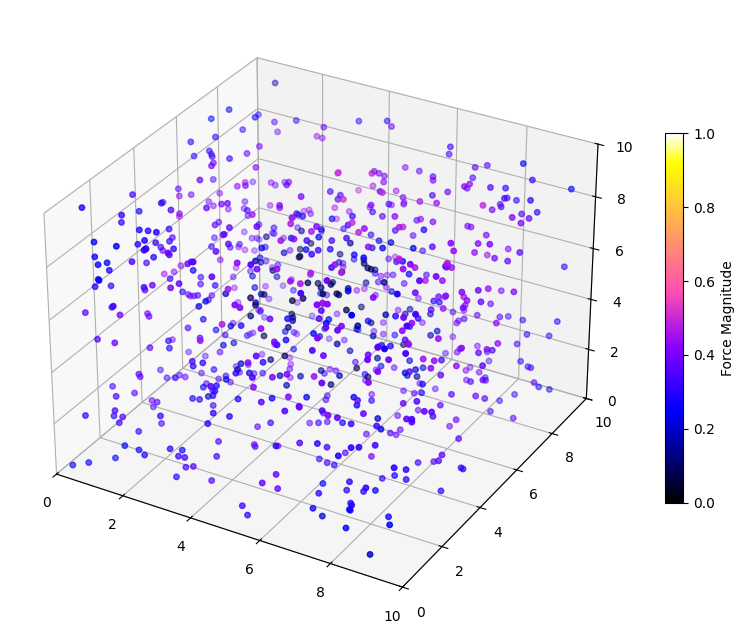

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
bounding = 0.5

if PBC:
    ax.set_xlim(0+bounding, lbox[0]-bounding)
    ax.set_ylim(0+bounding, lbox[1]-bounding)
    ax.set_zlim(0+bounding, lbox[2]-bounding)
else:
    ax.set_xlim(0, lbox[0])
    ax.set_ylim(0, lbox[1])
    ax.set_zlim(0, lbox[2])


max_force_norm = np.max(np.linalg.norm(f_storage, axis=2))

forces = f_storage[0]
force_norms = np.linalg.norm(forces, axis=1)  # Correct axis for norm calculation
initial_colors = force_norms / max_force_norm

scat = ax.scatter(r_storage[0, :, 0], r_storage[0, :, 1], r_storage[0, :, 2],
    s=radius**2/(lbox[0]*lbox[1]*lbox[2])*4e5/2,
    c=initial_colors,
    cmap='gnuplot2', vmin=0, vmax=1)

cbar = fig.colorbar(scat, ax=ax, shrink=0.6, aspect=20, label='Force Magnitude')

#quiver = ax.quiver(r_storage[0, :, 0], r_storage[0, :, 1], r_storage[0, :, 2],
#    f_storage[0, :, 0], f_storage[0, :, 1], f_storage[0, :, 2],
#    length=0.2, normalize=True)


def animate(ax, i):
    scat._offsets3d = (r_storage[i, :, 0], r_storage[i, :, 1], r_storage[i, :, 2])

    forces = f_storage[i]
    force_norms = np.linalg.norm(forces, axis=1)  # Correct axis for norm calculation
    force_norms_normalized = force_norms / max_force_norm

    scat.set_array(force_norms_normalized) # updates the color per point
#    quiver.set_segments(np.array([r_storage[i], r_storage[i] + forces/np.linalg.norm(forces, axis=1, keepdims=True)*0.2 ]).transpose(1, 0, 2))

    return scat#, quiver



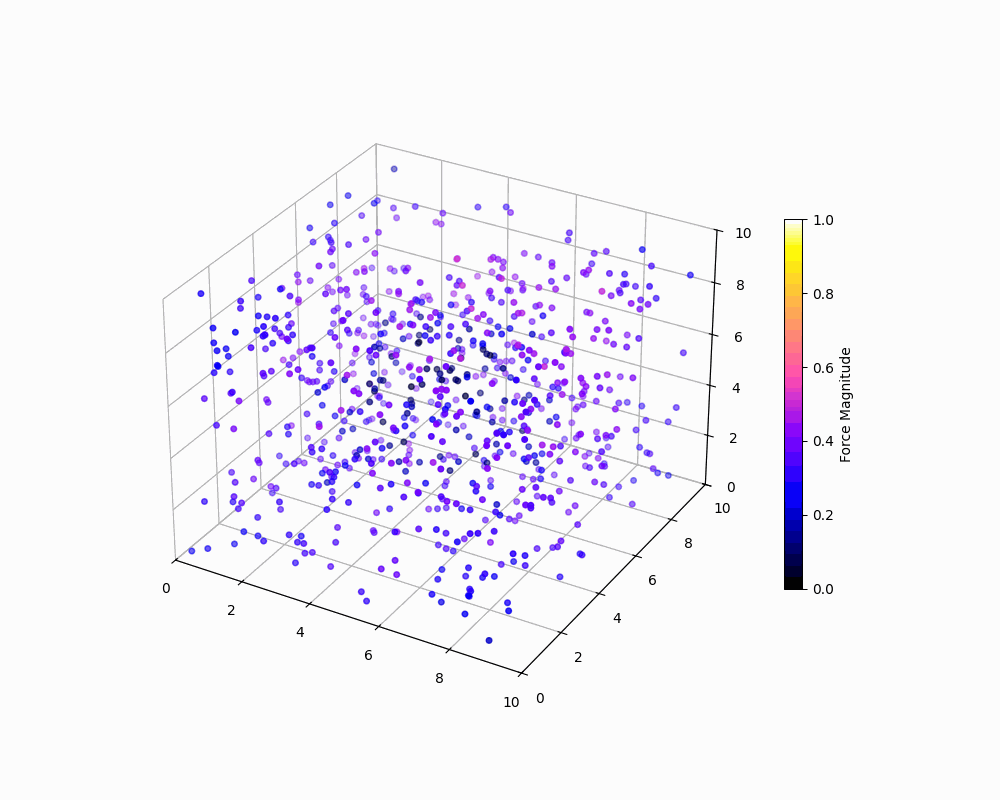

In [ ]:
from animator import ParticleAnimator
from matplotlib.animation import FFMpegWriter, PillowWriter
filename = '3danim.gif'
display_fps = 30


anim = ParticleAnimator(fig, PillowWriter, filename)
anim.set_display(display_fps, runtime)
frame_data = anim.generate_frame_data([i for i in range(len(r_storage))], update_fps=30)
anim.animate_ax(ax, animate, frame_data)
anim.make_animation()
anim.display()